# Skin Lesion Classification — Transfer Learning
**Dataset:** merged HAM10000 + MSLDv2.0 (14 classes).

This notebook trains a single transfer-learning model on the dataset using PyTorch. 
**Assumptions:** dataset arranged like:
```
data/
  train/
    class_1/
      img1.jpg
      img2.jpg
    class_2/
  val/
    class_1/
    ...
```

**Model:** EfficientNet-B0

In [1]:
# Environment & imports
# Install PyTorch with CUDA support (run this cell first if CUDA is not available)
# Your system has CUDA 12.7, so use cu124 (compatible with CUDA 12.x):
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Alternative for CUDA 12.1:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install other packages
%pip install torch torchvision matplotlib scikit-learn tqdm timm
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Force GPU usage
if not torch.cuda.is_available():
    print("CUDA not available. Installing CPU version of PyTorch...")
    # Install CPU version if GPU not available
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    device = torch.device("cpu")
    print("Using CPU. To use GPU, install CUDA and PyTorch with CUDA support.")
else:
    device = torch.device("cuda")
    print("Device:", device)
    print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "N/A")

Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Device: cuda
CUDA version: 12.4
Device: cuda
CUDA version: 12.4


In [2]:
# Paths (change these to your dataset locations)
train_dir = r"D:\archive\train"
val_dir   = r"D:\archive\val"

# Data transforms and augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)

batch_size = 32
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes ({}):".format(num_classes), class_names)
print("Train size:", len(train_dataset), " Val size:", len(val_dataset))


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train size: 10648  Val size: 1327


In [3]:
# Compute class weights to address imbalance
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [4]:
# EfficientNet-B0 (torchvision if available)
try:
    model = models.efficientnet_b0(pretrained=True)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
except Exception as e:
    # If torchvision doesn't have efficientnet in your environment, use timm (uncomment install if needed)
    # !pip install timm -q
    import timm
    model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
model = model.to(device)


c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nethm\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Optimizer, scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Optional scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = None
num_epochs = 30  # change as needed


In [6]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    history = {"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[], "val_f1":[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())

            epoch_loss = running_loss / (len(loader.dataset))
            epoch_acc = running_corrects / (len(loader.dataset))
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            print("{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}".format(phase, epoch_loss, epoch_acc, epoch_f1))

            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                # deep copy the model
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
        if scheduler is not None:
            scheduler.step()
        print("-"*30)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val F1: {:.4f}".format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [7]:
# Train
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs, model_name="EfficientNet-B0")


Epoch 1/30


100%|██████████| 333/333 [01:45<00:00,  3.16it/s]


train Loss: 1.3642 Acc: 0.4872 F1: 0.4715


100%|██████████| 42/42 [00:08<00:00,  4.74it/s]



val Loss: 0.8355 Acc: 0.7091 F1: 0.7101
------------------------------
Epoch 2/30


100%|██████████| 333/333 [01:32<00:00,  3.59it/s]


train Loss: 0.7516 Acc: 0.6842 F1: 0.6745


100%|██████████| 42/42 [00:08<00:00,  5.17it/s]



val Loss: 0.4983 Acc: 0.8078 F1: 0.8000
------------------------------
Epoch 3/30


100%|██████████| 333/333 [01:50<00:00,  3.02it/s]


train Loss: 0.6065 Acc: 0.7544 F1: 0.7362


100%|██████████| 42/42 [00:08<00:00,  5.03it/s]



val Loss: 0.3782 Acc: 0.8628 F1: 0.8586
------------------------------
Epoch 4/30


100%|██████████| 333/333 [01:32<00:00,  3.60it/s]


train Loss: 0.4939 Acc: 0.7930 F1: 0.7791


100%|██████████| 42/42 [00:08<00:00,  4.85it/s]


val Loss: 0.3262 Acc: 0.8764 F1: 0.8535
------------------------------
Epoch 5/30


100%|██████████| 333/333 [01:39<00:00,  3.35it/s]


train Loss: 0.4340 Acc: 0.8191 F1: 0.8097


100%|██████████| 42/42 [00:09<00:00,  4.64it/s]



val Loss: 0.2784 Acc: 0.8877 F1: 0.8763
------------------------------
Epoch 6/30


100%|██████████| 333/333 [01:38<00:00,  3.39it/s]


train Loss: 0.3996 Acc: 0.8353 F1: 0.8224


100%|██████████| 42/42 [00:09<00:00,  4.58it/s]



val Loss: 0.2261 Acc: 0.9126 F1: 0.8892
------------------------------
Epoch 7/30


100%|██████████| 333/333 [01:33<00:00,  3.58it/s]


train Loss: 0.3576 Acc: 0.8527 F1: 0.8403


100%|██████████| 42/42 [00:08<00:00,  5.11it/s]



val Loss: 0.2208 Acc: 0.9179 F1: 0.8938
------------------------------
Epoch 8/30


100%|██████████| 333/333 [01:36<00:00,  3.46it/s]


train Loss: 0.3291 Acc: 0.8647 F1: 0.8500


100%|██████████| 42/42 [00:08<00:00,  5.00it/s]



val Loss: 0.1638 Acc: 0.9352 F1: 0.9229
------------------------------
Epoch 9/30


100%|██████████| 333/333 [01:42<00:00,  3.25it/s]



train Loss: 0.3121 Acc: 0.8758 F1: 0.8654


100%|██████████| 42/42 [00:09<00:00,  4.53it/s]


val Loss: 0.1637 Acc: 0.9405 F1: 0.9189
------------------------------
Epoch 10/30


100%|██████████| 333/333 [01:43<00:00,  3.23it/s]


train Loss: 0.3002 Acc: 0.8756 F1: 0.8647


100%|██████████| 42/42 [00:08<00:00,  4.84it/s]


val Loss: 0.1622 Acc: 0.9420 F1: 0.9225
------------------------------
Epoch 11/30


100%|██████████| 333/333 [01:39<00:00,  3.36it/s]


train Loss: 0.2672 Acc: 0.8917 F1: 0.8802


100%|██████████| 42/42 [00:09<00:00,  4.58it/s]



val Loss: 0.1405 Acc: 0.9503 F1: 0.9331
------------------------------
Epoch 12/30


100%|██████████| 333/333 [01:39<00:00,  3.34it/s]


train Loss: 0.2648 Acc: 0.8957 F1: 0.8853


100%|██████████| 42/42 [00:08<00:00,  4.70it/s]



val Loss: 0.1414 Acc: 0.9533 F1: 0.9332
------------------------------
Epoch 13/30


100%|██████████| 333/333 [01:36<00:00,  3.46it/s]


train Loss: 0.2435 Acc: 0.8990 F1: 0.8954


100%|██████████| 42/42 [00:08<00:00,  5.00it/s]


val Loss: 0.1364 Acc: 0.9593 F1: 0.9296
------------------------------
Epoch 14/30


100%|██████████| 333/333 [01:36<00:00,  3.44it/s]


train Loss: 0.2350 Acc: 0.9051 F1: 0.8995


100%|██████████| 42/42 [00:08<00:00,  5.04it/s]



val Loss: 0.1404 Acc: 0.9548 F1: 0.9437
------------------------------
Epoch 15/30


100%|██████████| 333/333 [01:35<00:00,  3.50it/s]


train Loss: 0.2126 Acc: 0.9171 F1: 0.9117


100%|██████████| 42/42 [00:08<00:00,  4.98it/s]


val Loss: 0.1313 Acc: 0.9548 F1: 0.9383
------------------------------
Epoch 16/30


100%|██████████| 333/333 [01:38<00:00,  3.39it/s]


train Loss: 0.2067 Acc: 0.9156 F1: 0.9103


100%|██████████| 42/42 [00:08<00:00,  4.95it/s]


val Loss: 0.1332 Acc: 0.9608 F1: 0.9372
------------------------------
Epoch 17/30


100%|██████████| 333/333 [01:36<00:00,  3.44it/s]


train Loss: 0.2141 Acc: 0.9149 F1: 0.9057


100%|██████████| 42/42 [00:08<00:00,  4.96it/s]


val Loss: 0.1241 Acc: 0.9608 F1: 0.9427
------------------------------
Epoch 18/30


100%|██████████| 333/333 [01:41<00:00,  3.29it/s]


train Loss: 0.2039 Acc: 0.9204 F1: 0.9151


100%|██████████| 42/42 [00:08<00:00,  4.68it/s]



val Loss: 0.0901 Acc: 0.9661 F1: 0.9482
------------------------------
Epoch 19/30


100%|██████████| 333/333 [01:36<00:00,  3.46it/s]


train Loss: 0.1880 Acc: 0.9212 F1: 0.9174


100%|██████████| 42/42 [00:08<00:00,  4.77it/s]



val Loss: 0.0976 Acc: 0.9699 F1: 0.9483
------------------------------
Epoch 20/30


100%|██████████| 333/333 [01:40<00:00,  3.32it/s]


train Loss: 0.1811 Acc: 0.9264 F1: 0.9215


100%|██████████| 42/42 [00:08<00:00,  4.76it/s]


val Loss: 0.1035 Acc: 0.9683 F1: 0.9437
------------------------------
Epoch 21/30


100%|██████████| 333/333 [01:33<00:00,  3.57it/s]


train Loss: 0.1715 Acc: 0.9312 F1: 0.9280


100%|██████████| 42/42 [00:08<00:00,  5.14it/s]


val Loss: 0.1202 Acc: 0.9586 F1: 0.9350
------------------------------
Epoch 22/30


100%|██████████| 333/333 [01:34<00:00,  3.52it/s]


train Loss: 0.1822 Acc: 0.9258 F1: 0.9171


100%|██████████| 42/42 [00:08<00:00,  5.20it/s]


val Loss: 0.1161 Acc: 0.9623 F1: 0.9395
------------------------------
Epoch 23/30


100%|██████████| 333/333 [01:32<00:00,  3.60it/s]


train Loss: 0.1821 Acc: 0.9296 F1: 0.9213


100%|██████████| 42/42 [00:08<00:00,  5.02it/s]


val Loss: 0.1248 Acc: 0.9668 F1: 0.9437
------------------------------
Epoch 24/30


100%|██████████| 333/333 [01:37<00:00,  3.43it/s]


train Loss: 0.1601 Acc: 0.9339 F1: 0.9329


100%|██████████| 42/42 [00:09<00:00,  4.47it/s]



val Loss: 0.0974 Acc: 0.9691 F1: 0.9502
------------------------------
Epoch 25/30


100%|██████████| 333/333 [01:35<00:00,  3.50it/s]


train Loss: 0.1587 Acc: 0.9362 F1: 0.9300


100%|██████████| 42/42 [00:08<00:00,  5.05it/s]



val Loss: 0.1071 Acc: 0.9691 F1: 0.9570
------------------------------
Epoch 26/30


100%|██████████| 333/333 [01:31<00:00,  3.62it/s]


train Loss: 0.1621 Acc: 0.9370 F1: 0.9305


100%|██████████| 42/42 [00:08<00:00,  5.02it/s]


val Loss: 0.1117 Acc: 0.9706 F1: 0.9568
------------------------------
Epoch 27/30


100%|██████████| 333/333 [01:31<00:00,  3.63it/s]



train Loss: 0.1497 Acc: 0.9395 F1: 0.9325


100%|██████████| 42/42 [00:08<00:00,  5.08it/s]


val Loss: 0.1003 Acc: 0.9714 F1: 0.9563
------------------------------
Epoch 28/30


100%|██████████| 333/333 [01:31<00:00,  3.62it/s]


train Loss: 0.1528 Acc: 0.9357 F1: 0.9327


100%|██████████| 42/42 [00:08<00:00,  4.96it/s]


val Loss: 0.1371 Acc: 0.9646 F1: 0.9428
------------------------------
Epoch 29/30


100%|██████████| 333/333 [01:31<00:00,  3.62it/s]


train Loss: 0.1501 Acc: 0.9405 F1: 0.9333


100%|██████████| 42/42 [00:08<00:00,  4.99it/s]


val Loss: 0.1204 Acc: 0.9729 F1: 0.9569
------------------------------
Epoch 30/30


100%|██████████| 333/333 [01:32<00:00,  3.60it/s]


train Loss: 0.1327 Acc: 0.9442 F1: 0.9403


100%|██████████| 42/42 [00:08<00:00,  4.91it/s]

val Loss: 0.0950 Acc: 0.9774 F1: 0.9604
------------------------------
Training complete in 52m 46s
Best val F1: 0.9604


In [8]:
def plot_history(history, model_name="model"):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title(f"{model_name} Loss")

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title(f"{model_name} Accuracy")
    plt.show()


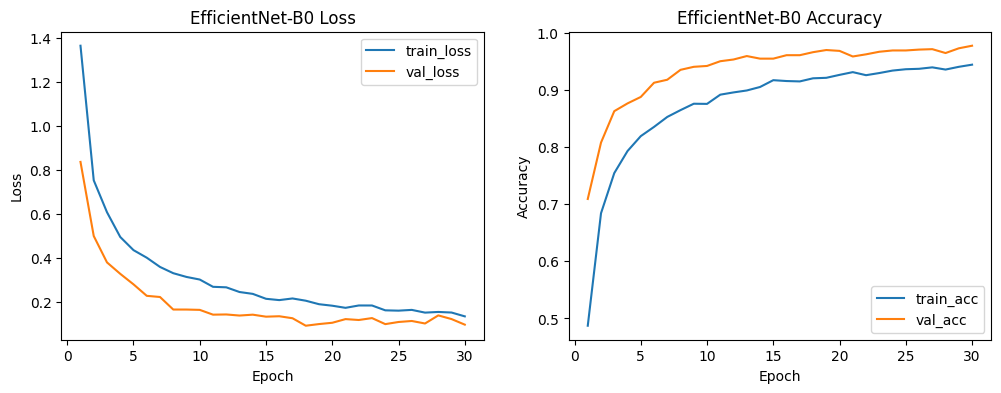

In [9]:
plot_history(history, model_name="EfficientNet-B0")


In [10]:
# Load best model checkpoint (if needed) and run final evaluation on validation set
def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)


In [11]:
evaluate_model(model)

                         precision    recall  f1-score   support

      Actinic keratoses       0.90      0.90      0.90        86
             Chickenpox       0.97      0.99      0.98       112
                 Cowpox       0.98      1.00      0.99        99
         Dermatofibroma       0.91      0.91      0.91        23
                   HFMD       0.99      1.00      1.00       241
                Healthy       0.99      1.00      0.99       171
                Measles       0.99      0.99      0.99        82
              Monkeypox       1.00      0.98      0.99       426
Squamous cell carcinoma       0.85      0.85      0.85        62
       Vascular lesions       1.00      1.00      1.00        25

               accuracy                           0.98      1327
              macro avg       0.96      0.96      0.96      1327
           weighted avg       0.98      0.98      0.98      1327

Confusion matrix:
 [[ 77   0   0   1   0   0   0   0   8   0]
 [  0 111   0   0   0   0

Note: you may need to restart the kernel to use updated packages.
Test classes order: ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Test size: 1337
Loaded checkpoint: EfficientNet-B0_best.pth
                         precision    recall  f1-score   support

      Actinic keratoses       0.89      0.88      0.88        88
             Chickenpox       0.94      1.00      0.97       113
                 Cowpox       0.98      1.00      0.99        99
         Dermatofibroma       1.00      0.92      0.96        25
                   HFMD       0.99      1.00      0.99       242
                Healthy       0.98      0.99      0.99       171
                Measles       0.98      0.98      0.98        83
              Monkeypox       1.00      0.97      0.98       426
Squamous cell carcinoma       0.84      0.88      0.85        64
       Vascular lesions       1.00      1.00     

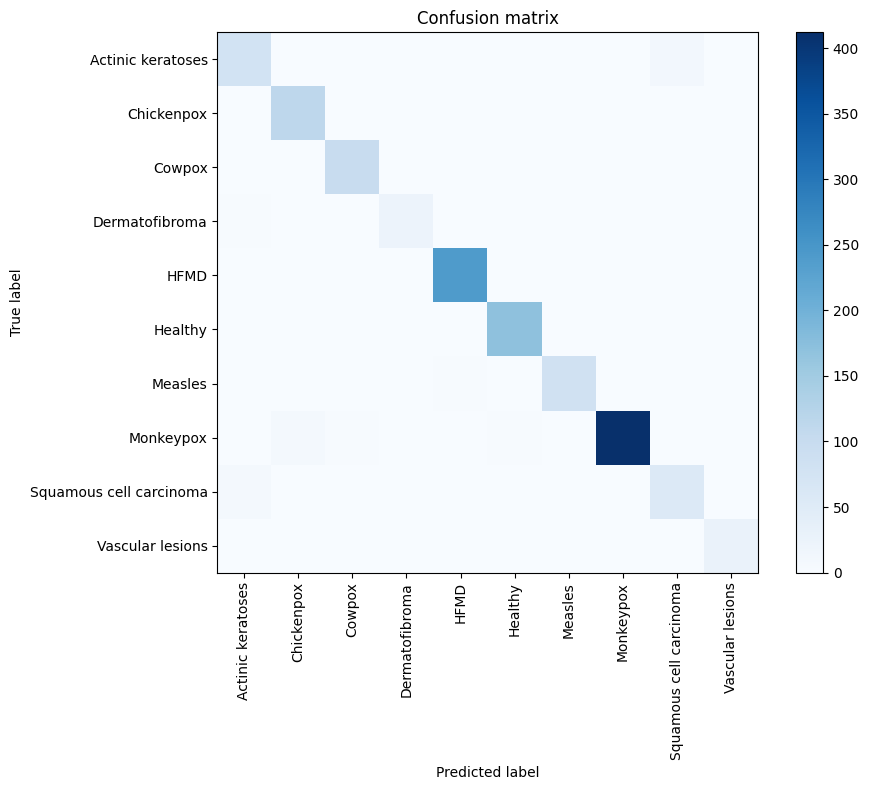

Saved test_predictions.csv


In [12]:

%pip install pandas
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# path to test data 
test_dir = r"D:\archive\test"   

# use same transforms as val_transforms to keep inputs consistent
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Test classes order:", test_dataset.classes)
print("Test size:", len(test_dataset))

# load best checkpoint (if you saved it during training)
ckpt_path = "EfficientNet-B0_best.pth"   # adjust if different
try:
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    print("Loaded checkpoint:", ckpt_path)
except Exception as e:
    print("Checkpoint load failed (using current model):", e)

model.to(device)
model.eval()

y_true = []
y_pred = []
probs = []   # optional: predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        ps = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())
        probs.extend(ps.cpu().numpy().tolist())

# metrics
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# optional: plot confusion matrix
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(test_dataset.classes))
plt.xticks(tick_marks, test_dataset.classes, rotation=90)
plt.yticks(tick_marks, test_dataset.classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# optional: save per-image predictions (filenames, true, pred, prob)
filenames = [p[0] for p in test_dataset.samples]  # full relative paths
df = pd.DataFrame({
    "file": filenames,
    "true": [test_dataset.classes[i] for i in y_true],
    "pred": [test_dataset.classes[i] for i in y_pred],
    "prob_top": [round(float(np.max(p)),4) for p in probs]
})
df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")

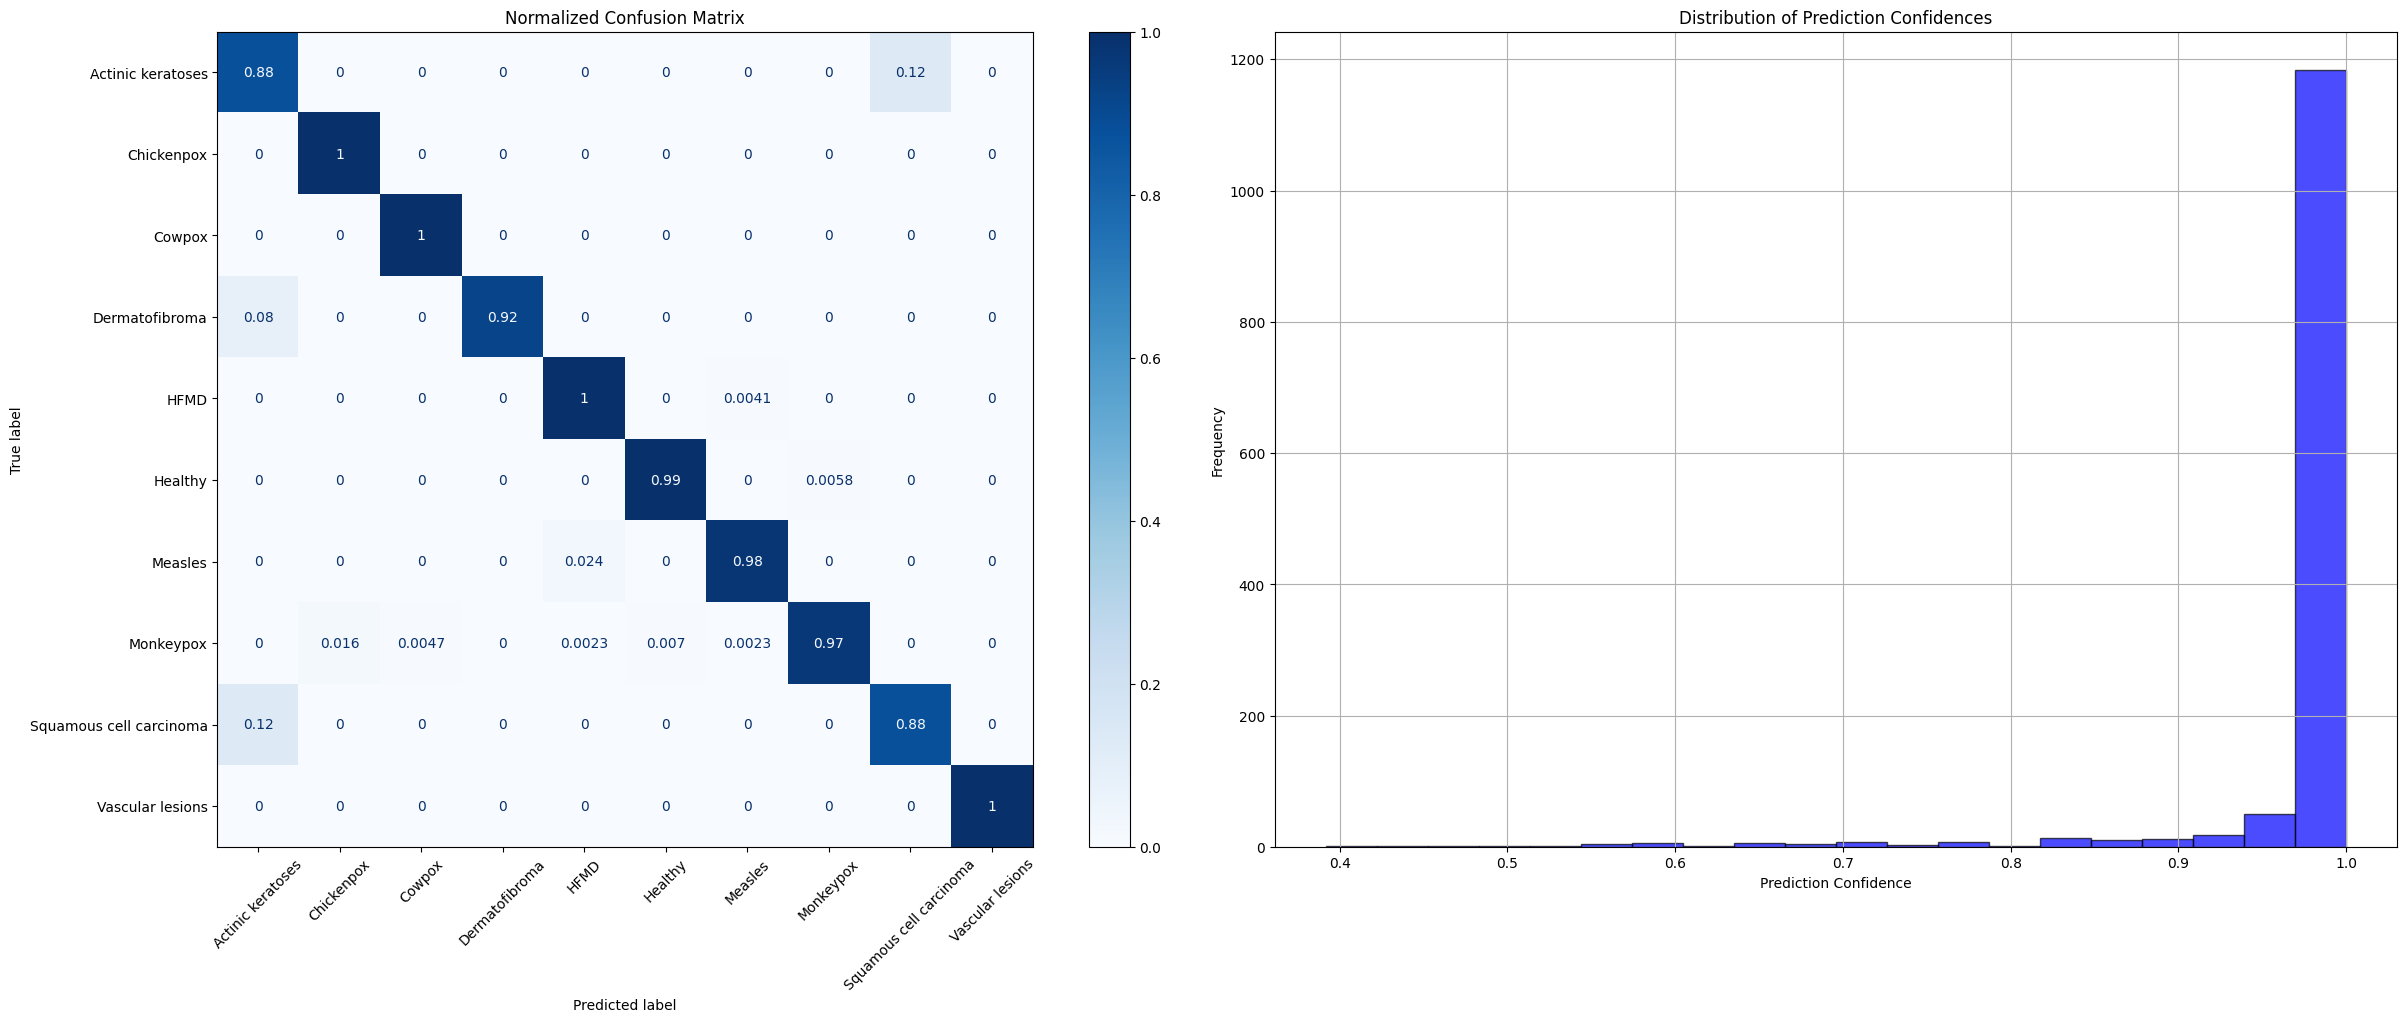

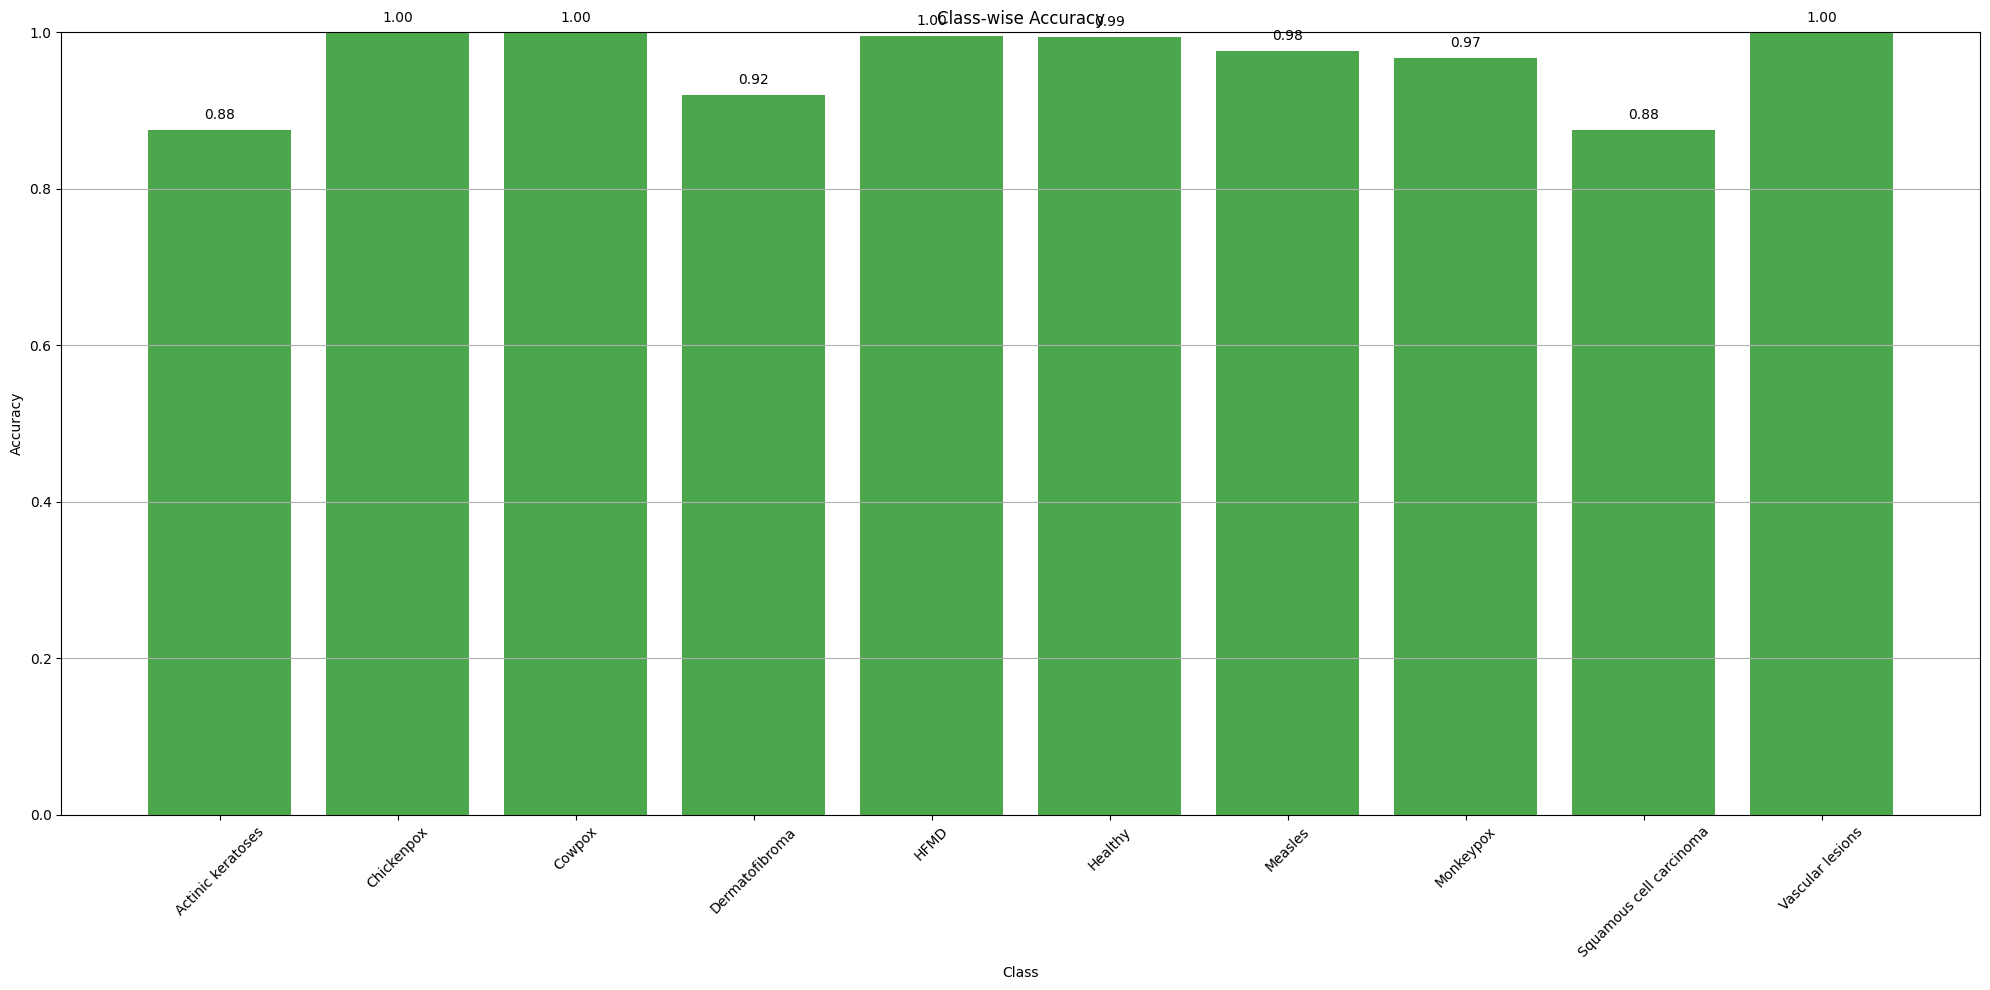

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Assuming class_names is available from earlier cells

# 1. Confusion Matrix and Histogram side by side (2 per row)
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Enhanced Confusion Matrix (left)
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=axes[0], xticks_rotation=45)
axes[0].set_title('Normalized Confusion Matrix')

# Histogram of Prediction Confidences (right)
top_probs = [np.max(p) for p in probs]
axes[1].hist(top_probs, bins=20, alpha=0.7, color='blue', edgecolor='black')
axes[1].set_xlabel('Prediction Confidence')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Prediction Confidences')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 2. Class-wise Accuracy as separate plot
plt.figure(figsize=(20, 10))
class_accuracies = []
for i in range(len(class_names)):
    mask = np.array(y_true) == i
    if np.sum(mask) > 0:
        acc = np.mean(np.array(y_pred)[mask] == i)
    else:
        acc = 0
    class_accuracies.append(acc)

plt.bar(range(len(class_names)), class_accuracies, color='green', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, v in enumerate(class_accuracies):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()